In [28]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re
import time

In [2]:
def scroll(driver, timeout, loops):
    scroll_pause_time = timeout

    last_height = driver.execute_script("return document.body.scrollHeight")
    num = 0
    
    while True and num < loops:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        num = num + 1
        time.sleep(scroll_pause_time)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

In [3]:
url = 'https://www.vivino.com/explore?e=eJwdijsOgCAQBW_zaqDfzo4jGGPWFQmJgAH83V5iM1PMxEIaMSRSiPyQ0UpBXhospMPi6NlvdHEJrvGOvFDhFpKvs-QzNWRaXRXcbZz6-st8itQcHw%3D%3D'
product_names = []
profile = webdriver.FirefoxProfile()
profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
options = Options()
options.headless = True
browser = webdriver.Firefox(options=options)
options.add_argument("start-maximized")
options.add_argument('disable-infobars')

def scrape():
    browser.get(url)
    loops = 1
    timeout = 5
    scroll(browser, timeout, loops)

    titles = browser.find_elements_by_class_name('vintageTitle__wine--U7t9G')
    prices = browser.find_elements_by_xpath("(//*[contains(@class, 'addToCartButton__price')])")
    ratings = browser.find_elements_by_class_name('vivinoRating__averageValue--3Navj')
    countries = browser.find_elements_by_xpath('//a[contains(@href, "/explore?country_code")]')
    
    for title, price, rating, country in zip(titles, prices, ratings, countries):
        with open('vinDataLarge.csv', 'a', encoding='UTF8') as f:
            writer = csv.writer(f)
            date = 9999
            line = re.findall(r'\d+', title.text)
        
            if(len(line)>0):
                for l in line:
                    if(len(str(l)) == 4):
                        date = l
                    
            data = [title.text, date, price.text.split("\n", 1)[0], rating.text, country.text]
            writer.writerow(data)
                                

In [4]:
#scrape()

In [51]:
df = pd.read_csv('vinData.csv')
print(len(df))
df.head()

3279


,Name,Year,Price,Rating,Link,Country
0,Edizione Cinque Autoctoni,9999.0,149.00,4.3,57775.0,Italy
1,Malbec 2016,2016.0,69.95,3.6,16818.0,Argentina
2,Malbec 2018,2018.0,59.95,3.8,16779.0,Argentina
3,Malbec 2016,2016.0,129.95,4.1,16138.0,Argentina
4,Cabernet Sauvignon 2016,2016.0,1245.00,4.6,13945.0,United States


In [54]:
yearMask = df['Year'] < 2022
dfClean = df[yearMask]
dfClean.head()

,Name,Year,Price,Rating,Link,Country
1,Malbec 2016,2016.0,69.95,3.6,16818.0,Argentina
2,Malbec 2018,2018.0,59.95,3.8,16779.0,Argentina
3,Malbec 2016,2016.0,129.95,4.1,16138.0,Argentina
4,Cabernet Sauvignon 2016,2016.0,1245.00,4.6,13945.0,United States
5,Malbec 2013,2013.0,99.95,3.9,13271.0,Argentina




## SAMMENHÆNG I DATAENS COLUMNS
Vi ville undersøge om der er en correlation mellem f.eks. år og pris, pris og rating, og så videre.

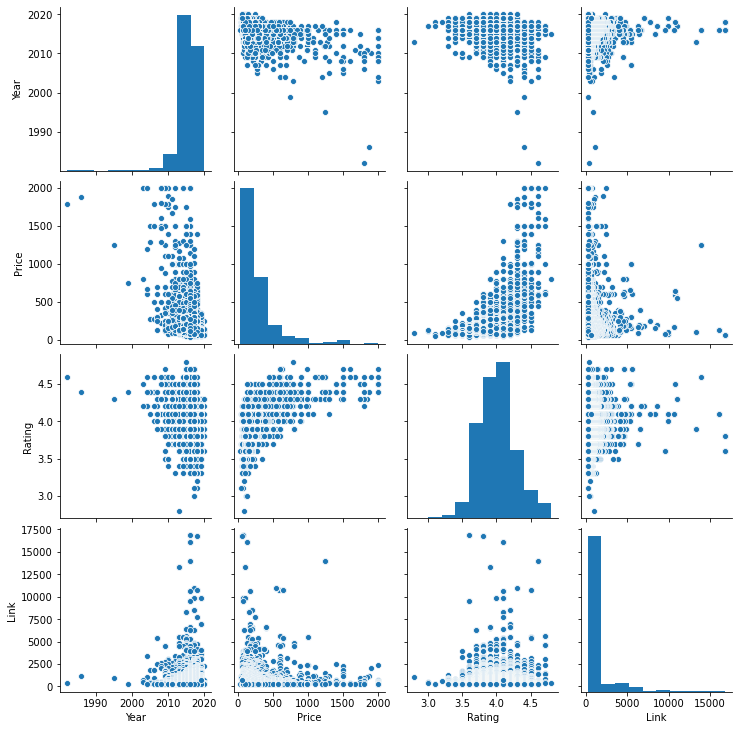

In [31]:
import seaborn as sb

sb.pairplot(dfClean)

In [32]:
dfClean.corr()

,Year,Price,Rating,Link
Year,1.000000,-0.446571,-0.231731,0.018987
Price,-0.446571,1.000000,0.647058,-0.001214
Rating,-0.231731,0.647058,1.000000,0.123031
Link,0.018987,-0.001214,0.123031,1.000000


In [52]:
#dfLarge = pd.read_csv('vinDataLarge.csv')
#yearMask = dfLarge['Year'] < 2022
#dfLargeClean = dfLarge[yearMask]

#dfLargeClean.corr()

0.6470579043387337


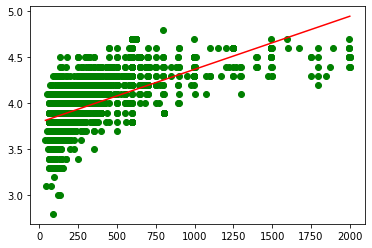

In [53]:
x = dfClean['Price']
y = dfClean['Rating']

plt.scatter(x, y, color='g')


plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
correlation = x.corr(y)
print(correlation)

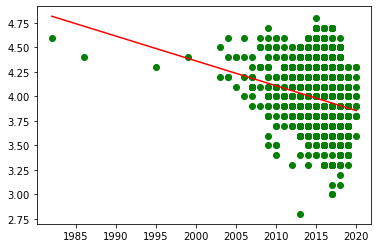

In [35]:
x = dfClean['Year']
y = dfClean['Rating']
plt.scatter(x, y, color='g')

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')

Vi kan se at desto større databasen er, desto stærkere er correlationen mellem pris og rating. Ville der være årsag til at scrape endnu mere?

In [41]:
print(len(dfClean))
for size in range(300, 3200, 200):
    print("Correlation ved størrelse " + str(size) + ": " + str(dfClean['Year'][0:size].corr(dfClean['Rating'][0:size])))

3258
Correlation ved størrelse 300: -0.2630798403260409
Correlation ved størrelse 500: -0.20867129158030726
Correlation ved størrelse 700: -0.15322350900882656
Correlation ved størrelse 900: -0.18200931898088302
Correlation ved størrelse 1100: -0.18544724161276194
Correlation ved størrelse 1300: -0.2027121313452922
Correlation ved størrelse 1500: -0.22509326086905834
Correlation ved størrelse 1700: -0.2405081417006017
Correlation ved størrelse 1900: -0.24218432265887038
Correlation ved størrelse 2100: -0.25813968943259
Correlation ved størrelse 2300: -0.25658840675289607
Correlation ved størrelse 2500: -0.2494570038926643
Correlation ved størrelse 2700: -0.24356665707937042
Correlation ved størrelse 2900: -0.23862145172212637
Correlation ved størrelse 3100: -0.23441250434903466


Videre undersøgning af hvor stærk correlationen er:

In [55]:
from sklearn.linear_model import LinearRegression
x = (dfClean['Price'].values).reshape(-1,1)
y = (dfClean['Rating'].values)
reg = LinearRegression().fit(x, y)

print(reg.score(x, y)); print(reg.coef_); print(reg.intercept_)

print(reg.predict([[1250]]))
print("Vi kan forvente at en vin til prisen 1250kr. har en rating på:"); print(0.00056345 * 1250 + 3.81)


0.4186839315672338
[0.00057644]
3.793550510426051
[4.51409698]
Vi kan forvente at en vin til prisen 1250kr. har en rating på:
4.5143125


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

dfTrain = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dfTrain

print(dfTrain[60:75])
r2_score(dfTrain['Actual'], dfTrain['Predicted'])

    Actual  Predicted
60     3.6   3.885155
61     4.1   3.966226
62     4.0   3.862694
63     3.8   3.897205
64     3.8   3.846428
65     4.1   3.835114
66     3.8   3.867899
67     3.9   3.911613
68     4.0   3.936921
69     3.9   3.867899
70     4.1   3.868446
71     4.1   3.965680
72     4.2   3.879949
73     4.7   4.138779
74     4.0   3.951875


0.4287458895854984

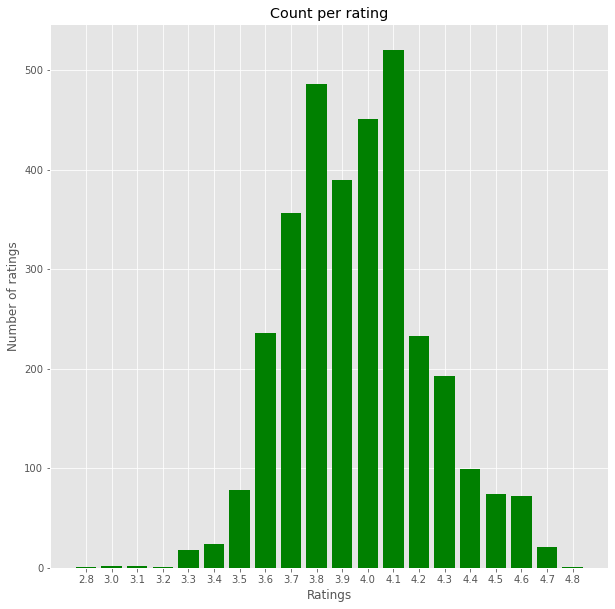

Float64Index([2.8, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1,
              4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8],
             dtype='float64')
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [166]:
%matplotlib inline

dfratings = dfClean.Rating.unique()
ratings = dfratings.sort()

plotdata = pd.DataFrame(0, index=dfratings, columns=['Count'])

loop = 0
for r in dfratings: 
    for row in dfClean['Rating']:
        if(row == r):
            plotdata['Count'].iloc[loop] = plotdata['Count'].iloc[loop] + 1
    loop += 1
   
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))
x = plotdata.index
y = plotdata['Count']
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y, color='green')
plt.xlabel("Ratings")
plt.ylabel("Number of ratings")
plt.title("Overview of number")

plt.xticks(x_pos, x)

plt.show()

print(x)
print([i for i, _ in enumerate(x)])

## Hvilken type vin var mest populær det givne år?

In [48]:
dfClean.head()

,Name,Year,Price,Rating,Link,Country
1,Malbec 2016,2016.0,69.95,3.6,16818.0,Argentina
2,Malbec 2018,2018.0,59.95,3.8,16779.0,Argentina
3,Malbec 2016,2016.0,129.95,4.1,16138.0,Argentina
4,Cabernet Sauvignon 2016,2016.0,1245.00,4.6,13945.0,United States
5,Malbec 2013,2013.0,99.95,3.9,13271.0,Argentina


In [61]:
data_chart = dfClean.drop(columns=['Price', 'Link'])
data_chart.head()

,Name,Year,Rating,Country
1,Malbec 2016,2016.0,3.6,Argentina
2,Malbec 2018,2018.0,3.8,Argentina
3,Malbec 2016,2016.0,4.1,Argentina
4,Cabernet Sauvignon 2016,2016.0,4.6,United States
5,Malbec 2013,2013.0,3.9,Argentina


In [62]:
#Viser hvilken vin der var bedst for hvert år, samt hvilket land den kom fra. 
max_rating = data_chart.groupby('Year').max()
max = max_rating['Rating'].max()
min_rating = data_chart.groupby('Year').min()
#min_rating
max_rating
#max


,Name,Rating,Country
Year,,,
1982.0,Barolo Riserva 1982,4.6,Italy
1986.0,Cos d'Estournel 1986,4.4,France
1995.0,Saint-Julien (Grand Cru Classé) 1995,4.3,France
1999.0,Lazzarito Barolo 1999,4.4,Italy
2003.0,Saint-Julien (Grand Cru Classé) 2003,4.5,United States
2004.0,Saint-Julien (Grand Cru Classé) 2004,4.6,Lebanon
2005.0,Viña Bosconia Reserva 2005,4.4,Spain
2006.0,Viña Bosconia Reserva 2006,4.6,United States
2007.0,Viña Tondonia Reserva Blanco 2007,4.4,Spain


In [64]:
newdf = max_rating.groupby('Name').max()
newdf

,Rating,Country
Name,,
Barolo Riserva 1982,4.6,Italy
Cos d'Estournel 1986,4.4,France
Lazzarito Barolo 1999,4.4,Italy
Saint-Julien (Grand Cru Classé) 1995,4.3,France
Saint-Julien (Grand Cru Classé) 2003,4.5,United States
Saint-Julien (Grand Cru Classé) 2004,4.6,Lebanon
Vinum Vita Est Barolo 2010,4.6,United States
Viña Bosconia Reserva 2005,4.4,Spain
Viña Bosconia Reserva 2006,4.6,United States


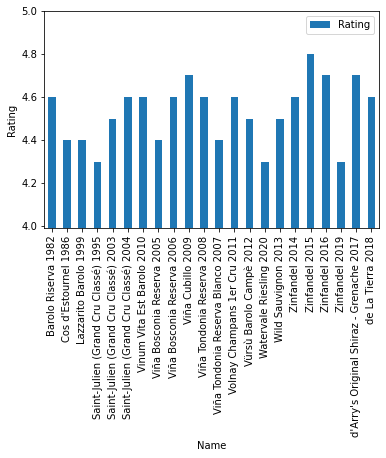

In [65]:
ax = newdf.plot.bar()
ax.set_ylim([3.99,5])
ax.set_ylabel('Rating')
ax

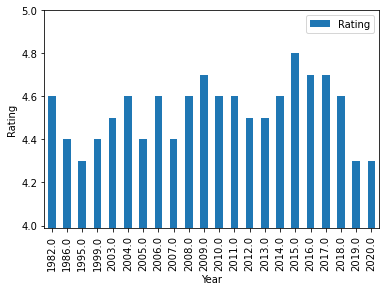

In [66]:
ax = max_rating.plot.bar()
ax.set_ylim([3.99,5])
ax.set_ylabel('Rating')
ax

In [68]:
#Hvilket land har haft den bedste vin flest gange.
no_of_occur_max = max_rating['Country'].value_counts()
no_of_occur_max

#Hvilket land har haft den dårligste vin flest gange.
#no_of_occur_min = min_rating['Country'].value_counts()
#no_of_occur_min


United States    7
Uruguay          5
Spain            5
France           2
Italy            2
Lebanon          1
Name: Country, dtype: int64